In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pat = pd.read_csv('../../eICU_dbmake/eicu-code/build-db/postgres/csv_files/patient.csv')
admdx = pd.read_csv('../../eICU_dbmake/eicu-code/build-db/postgres/csv_files/admissionDx.csv')
qual_adm = pd.read_csv('../data/intermediate/patid_aki_label_offset.csv', header=None)
lab_vit = pd.read_csv('../data/intermediate/lab_vital_merged_time.csv')

/Users/zhannahakhverdyan/anaconda3/envs/predict_dialisys_need/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
qual_adm.columns = ['patientunitstayid', 'aki_label', 'aki_offset']
qual_adm.set_index('patientunitstayid', inplace=True)

In [4]:
print(len(pat))
pat = pat.merge(qual_adm, left_on = 'patientunitstayid', right_on = 'patientunitstayid')
print(len(pat))

200859
90805


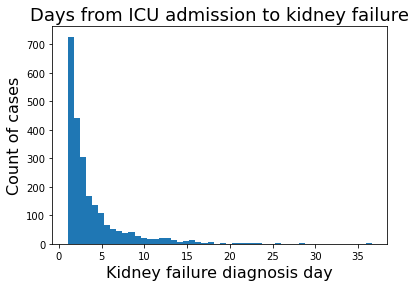

In [14]:
# distribution of aki diagnosis times
offset_hour = qual_adm[qual_adm.aki_label==1]['aki_offset']/(60*24)
offset_hour.sort_values(inplace=True)
offset_hour.hist(bins=50)
plt.ylabel('Count of cases', fontsize=16)
plt.xlabel('Kidney failure diagnosis day', fontsize=16)
plt.title('Days from ICU admission to kidney failure', fontsize=18);
plt.grid(b=None)

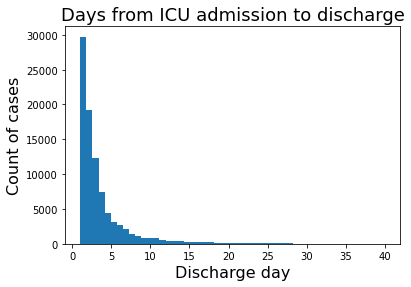

In [15]:
# distribution of overall patient discharges
disch_offset_day = pat['unitdischargeoffset']/(60*24)
disch_offset_day.sort_values(inplace=True)
disch_offset_day[disch_offset_day<=40].hist(bins=50)
plt.ylabel('Count of cases', fontsize=16)
plt.xlabel('Discharge day', fontsize=16)
plt.title('Days from ICU admission to discharge', fontsize=18);
plt.grid(b=None)

Both events are Poisson distributed.

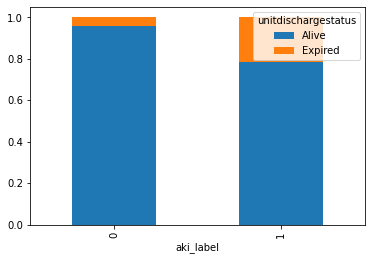

In [28]:
# look at mortality by aki_label
label_alive_sum = pat.groupby(['aki_label', 'unitdischargestatus'])['patientunitstayid'].count()
label_alive_sum = label_alive_sum.unstack(level=1)
label_alive_sum['total'] = label_alive_sum['Alive']+label_alive_sum['Expired']
label_alive_sum['Alive'] = label_alive_sum['Alive']/label_alive_sum['total']
label_alive_sum['Expired'] = label_alive_sum['Expired']/label_alive_sum['total']
label_alive_sum[['Alive', 'Expired']].plot(kind='bar', stacked=True)

Mortality rates are very different for AKI positive and negative patients. This is expected.

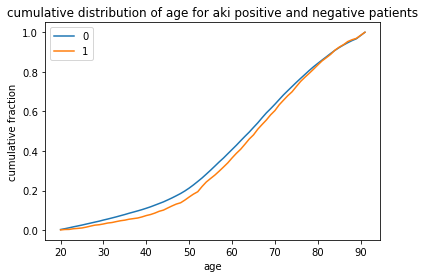

In [33]:
# look at age distribution
pat.loc[pat.age == '> 89', 'age'] = 91
pat['age'] = pat['age'].astype(int)
age_dist_grouped = pat.groupby('aki_label')['age'].value_counts()
age_dist_grouped = age_dist_grouped.unstack(level=0)
age_dist_grouped = pd.DataFrame(age_dist_grouped.values, index=age_dist_grouped.index.tolist(), \
columns=age_dist_grouped.columns.tolist())
age_dist_grouped.sort_index(inplace=True)
age_dist_grouped = age_dist_grouped/age_dist_grouped.sum(axis=0)
age_dist_cumulative = age_dist_grouped.cumsum()
age_dist_cumulative.plot()
plt.xlabel('age')
plt.ylabel('cumulative fraction')
plt.title('cumulative distribution of age for aki positive and negative patients');

Patients with AKI are slightly older but not by much.

In [57]:
# merge qualifying admissions and admission diagnosis
# need to extract organ system and O.R. features
admdx = admdx.merge(qual_adm, left_on = 'patientunitstayid', right_on = 'patientunitstayid')

admdx['organ_system'] = admdx['admitdxpath'].str.split(pat="\|Organ System\|", n=1).str[1]
admdx['from_OR'] = admdx['admitdxpath'].str.split(pat="O.R. within 4 hours of admission\?\|", n=1).str[1]

or_summary = admdx.groupby('patientunitstayid')['from_OR'].apply(lambda x: x.str.cat(sep=' '))
print(or_summary.value_counts())

No     71927
Yes    18878
Name: from_OR, dtype: int64


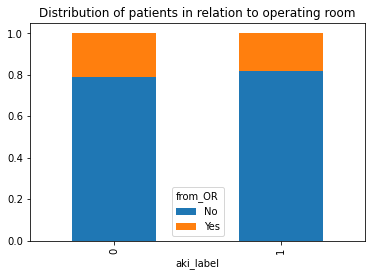

In [54]:
label_admdx_sum = admdx.groupby(['aki_label', 'from_OR'])['patientunitstayid'].count()
label_admdx_sum = label_admdx_sum.unstack(level=1)

label_admdx_sum['total'] = label_admdx_sum['No']+label_admdx_sum['Yes']
label_admdx_sum['No'] = label_admdx_sum['No']/label_admdx_sum['total']
label_admdx_sum['Yes'] = label_admdx_sum['Yes']/label_admdx_sum['total']
label_admdx_sum[['No', 'Yes']].plot(kind='bar', stacked=True)
plt.title('Distribution of patients in relation to operating room');

1/4-1/5 of patients came from operating room, no difference in fractions.

In [35]:
diag_summary = admdx.groupby('patientunitstayid')['organ_system'].apply(lambda x: x.str.cat(sep=' '))
print(diag_summary.value_counts())
print(diag_summary.isnull().sum())

Cardiovascular          38790
Neurologic              17144
Respiratory             14958
Gastrointestinal         9615
Trauma                   4247
Metabolic/Endocrine      3244
Musculoskeletal/Skin     1138
Genitourinary             968
Hematology                585
Transplant                116
Name: organ_system, dtype: int64
0


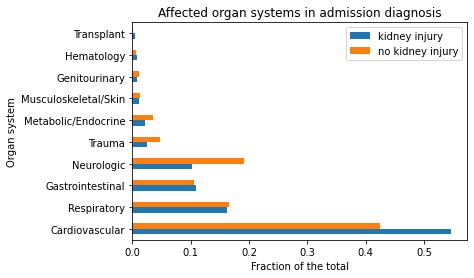

In [46]:
diag_summary_label = pd.concat([diag_summary, qual_adm], axis=1, ignore_index=False)
pos_organ = diag_summary_label[diag_summary_label.aki_label==1]['organ_system'].value_counts()/len(diag_summary_label[diag_summary_label.aki_label==1])
neg_organ = diag_summary_label[diag_summary_label.aki_label==0]['organ_system'].value_counts()/len(diag_summary_label[diag_summary_label.aki_label==0])
combined_organ = pd.concat([pos_organ, neg_organ], axis=1)
combined_organ.columns=['kidney injury', 'no kidney injury']
combined_organ.plot.barh()
plt.ylabel('Organ system')
plt.xlabel('Fraction of the total')
plt.title('Affected organ systems in admission diagnosis');
                           

Organ system distribution appears different

In [59]:
# gender, ethnicity, ICU type have been plotted before and appear no different
pat.set_index('patientunitstayid', inplace=True)
admdx.set_index('patientunitstayid', inplace=True)
#lab_vit.set_index('patientunitstayid', inplace=True)
combined_df = pd.concat([pat, diag_summary, or_summary, lab_vit], axis=1)
combined_df.columns.tolist()

['patienthealthsystemstayid',
 'gender',
 'age',
 'ethnicity',
 'hospitalid',
 'wardid',
 'apacheadmissiondx',
 'admissionheight',
 'hospitaladmittime24',
 'hospitaladmitoffset',
 'hospitaladmitsource',
 'hospitaldischargeyear',
 'hospitaldischargetime24',
 'hospitaldischargeoffset',
 'hospitaldischargelocation',
 'hospitaldischargestatus',
 'unittype',
 'unitadmittime24',
 'unitadmitsource',
 'unitvisitnumber',
 'unitstaytype',
 'admissionweight',
 'dischargeweight',
 'unitdischargetime24',
 'unitdischargeoffset',
 'unitdischargelocation',
 'unitdischargestatus',
 'uniquepid',
 'aki_label',
 'aki_offset',
 'organ_system',
 'from_OR',
 'min_sao2',
 'max_sao2',
 'mean_sao2',
 'min_heartrate',
 'max_heartrate',
 'mean_heartrate',
 'min_respiration',
 'max_respiration',
 'mean_respiration',
 'days_of_data',
 'min_result_BUN',
 'min_result_FiO2',
 'min_result_HCO3',
 'min_result_Hct',
 'min_result_Hgb',
 'min_result_MCH',
 'min_result_MCHC',
 'min_result_MCV',
 'min_result_MPV',
 'min_resu

In [65]:
combined_df[combined_df['days_of_data']==5]['organ_system'].value_counts()

Cardiovascular          6008
Respiratory             3457
Neurologic              2971
Gastrointestinal        1355
Trauma                  1000
Musculoskeletal/Skin     227
Metabolic/Endocrine      171
Genitourinary             67
Hematology                65
Transplant                24
Name: organ_system, dtype: int64

In [70]:
# generate dummy set for splitting
dummy_set = combined_df.groupby('patienthealthsystemstayid')['aki_label'].sum()
dummy_set

patienthealthsystemstayid
128948     0
129017     0
129020     0
129080     0
129082     0
          ..
2743007    0
2743053    1
2743055    1
2743064    0
2743066    0
Name: aki_label, Length: 85704, dtype: int64

In [73]:
dummy_set.loc[dummy_set> 1]=1

In [76]:
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(dummy_set, test_size=0.2)
train, val = train_test_split(train_val, test_size=0.2)
print(sum(train)/len(train))
print(sum(val)/len(val))
print(sum(test)/len(test))

0.027092069279854147
0.027492160723401153
0.026894580246193338


In [78]:
combined_df.reset_index(inplace=True)
combined_df.set_index('patienthealthsystemstayid', inplace=True)
combined_df

,patientunitstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,...,delta_result_creatinine,delta_result_glucose,delta_result_magnesium,delta_result_pH,delta_result_paCO2,delta_result_paO2,delta_result_platelets x 1000,delta_result_potassium,delta_result_sodium,unitdischargestatus_alive
patienthealthsystemstayid,,,,,,,,,,,,,,,,,,,,,
128948,141203,Female,77,Caucasian,66,90,"Arrest, respiratory (without cardiac arrest)",160.0,22:23:00,-1336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
129017,141284,Male,63,Caucasian,73,92,Anemia,188.0,23:10:00,-15,...,0.00,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
129020,141288,Female,61,Caucasian,67,109,"Sepsis, pulmonary",162.6,17:32:00,-171,...,0.00,0.0,NaN,0.000,0.0,0.0,4.0,0.0,0.0,1.0
129080,141360,Male,48,Caucasian,73,102,"CVA, cerebrovascular accident/stroke",175.3,18:39:00,-30,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,1.0
129082,141362,Male,65,Caucasian,73,93,"Cholecystectomy/cholangitis, surgery for (gall...",172.7,21:03:00,-1505,...,0.00,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743055,3353198,Female,66,Caucasian,458,1106,Coma/change in level of consciousness (for hep...,157.5,06:38:00,-68542,...,0.59,116.0,0.1,0.093,7.4,26.0,100.0,1.3,16.0,1.0
2743055,3353200,Female,66,Caucasian,458,1109,"Hypovolemia (including dehydration, Do not inc...",157.5,06:38:00,-133891,...,0.08,77.0,0.0,0.000,0.0,0.0,27.0,0.3,2.0,1.0
2743055,3353201,Female,66,Caucasian,458,1109,"Effusions, pleural",157.5,06:38:00,-58037,...,0.34,94.0,0.1,0.000,0.0,0.0,39.0,1.4,1.0,1.0


In [79]:
# drop cols I will not use 
cols_to_drop = ['hospitalid',
 'wardid',
 'apacheadmissiondx',
 'admissionheight',
 'hospitaladmittime24',
 'hospitaladmitoffset',
 'hospitaladmitsource',
 'hospitaldischargeyear',
 'hospitaldischargetime24',
 'hospitaldischargeoffset',
 'hospitaldischargelocation',
 'hospitaldischargestatus',
 'hospitalid',
 'wardid',
 'apacheadmissiondx',
 'admissionheight',
 'hospitaladmittime24',
 'hospitaladmitoffset',
 'hospitaladmitsource',
 'hospitaldischargeyear',
 'hospitaldischargetime24',
 'hospitaldischargeoffset',
 'hospitaldischargelocation',
 'hospitaldischargestatus',
 'unitdischargelocation',
 'uniquepid']
combined_df.drop(columns=cols_to_drop, inplace=True)

In [80]:
train_df = combined_df.merge(train, right_index=True, left_index=True)
val_df = combined_df.merge(val, right_index=True, left_index=True)
test_df = combined_df.merge(test, right_index=True, left_index=True)
print(len(train_df))
print(len(val_df))
print(len(test_df))

58149
14491
18165


In [81]:
train_df.head()

,patientunitstayid,gender,age,ethnicity,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,...,delta_result_glucose,delta_result_magnesium,delta_result_pH,delta_result_paCO2,delta_result_paO2,delta_result_platelets x 1000,delta_result_potassium,delta_result_sodium,unitdischargestatus_alive,aki_label_y
patienthealthsystemstayid,,,,,,,,,,,,,,,,,,,,,
128948,141203,Female,77,Caucasian,Med-Surg ICU,20:39:00,Floor,1,admit,70.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
129017,141284,Male,63,Caucasian,CTICU,23:25:00,Direct Admit,1,admit,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0
129080,141360,Male,48,Caucasian,Neuro ICU,19:09:00,Emergency Department,1,admit,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,1.0,0
129260,141584,Male,63,Caucasian,MICU,01:32:00,Emergency Department,1,admit,134.0,...,11.0,0.0,0.10,11.0,28.0,20.0,0.5,1.0,1.0,0
129260,141585,Male,63,Caucasian,MICU,12:19:00,Floor,3,readmit,136.6,...,60.0,0.5,0.24,73.0,276.0,36.0,1.0,2.0,1.0,0


In [82]:
train_df.reset_index(inplace=True)
train_df.drop('aki_label_y', axis=1, inplace=True)
train_df = train_df.rename(columns={'aki_label_x': 'aki_label'})
train_df['aki_label']

0        0
1        0
2        0
3        0
4        0
        ..
58144    0
58145    0
58146    0
58147    0
58148    0
Name: aki_label, Length: 58149, dtype: int64

In [83]:
val_df.reset_index(inplace=True)
val_df.drop('aki_label_y', axis=1, inplace=True)
val_df = val_df.rename(columns={'aki_label_x': 'aki_label'})

test_df.reset_index(inplace=True)
test_df.drop('aki_label_y', axis=1, inplace=True)
test_df = test_df.rename(columns={'aki_label_x': 'aki_label'})

In [84]:
train_df.to_csv('../data/final/train_spliton_pat.csv')
val_df.to_csv('../data/final/val_spliton_pat.csv')
test_df.to_csv('../data/final/test_spliton_pat.csv')